# U-Net Implementation

U-Net is a convolutional neural network architecture originllay designed for biomedical image segmentation tasks. 
Its name is derived from its U-shaped structure, which consists of a contracting path to capture context and a symmetric expanding path for precise localization.
Some common uses of U-Nets are:
- *Biomedical Image Segmentation*: Segmentation of organs, tissues, and cells in medical images.
- *Cell Tracking*: Tracking the movement and behavior of cells over time in microscopic images.
- *Nucleus Detection*: Identifying and delineating cell nuclei in histology images.
- *Lesion Detection*: Detecting and segmenting lesions or abnormalities in medical scans.

U-Net's architecture is versatile, and it has been adapted for tasks such as satellite image segmentation, road detection, etc.

The goal of this notebook is to provide an understanding of U-Net architecture by implementing the basic structure of a U-Net model.

Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597v1)

## Architecture

U-Net can be thought of as an **encoder-decoder** architecture. The encoder part captures the context of the input image through convolutional and pooling layers, reducing its spatial dimensions while increasing feature depth. The decoder part then recovers the spatial information by employing upsampling operations along with convolutional layers.

In [1]:
import torch
import torch.nn as nn

In [2]:
class SimpleUNet(nn.Module):
    """
    Simple U-Net model with 2x downsampling and 2x upsampling.
    It has 3 input channels and 1 output channel.
    """
    def __init__(
            self,
            in_channels: int = 3,
            out_channels: int = 1):
        super().__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)

        # Upsampling layer. It doubles the size of the input.
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Decoder
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.conv4 = nn.Conv2d(16, out_channels, 3)
        
    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.upsample(x2)

        # Decoder
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)

        return x5

In [3]:
test_input = torch.randn(1, 3, 256, 256)
simple_model = SimpleUNet()
test_output = simple_model(test_input)

print("Input shape:", test_input.shape)
print("Output shape:", test_output.shape)

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 500, 500])


#### Encoder

- The encoder typically consists of a series of convolutional layers followed by max-pooling layers.
- Convolutional layers help extract features from the input image.
- Max pooling layers downsample the feature maps to capture the most salient features.

In [4]:
class Downscaling(nn.Module):
    """ Downscaling block with 2x downsampling """
    def __init__(self, in_channels, out_channels):
        super(Downscaling, self).__init__()
        self.maxpool = nn.MaxPool2d(2) # Maxpooling layer
        # 3x3 convolutions with batch normalization and ReLU activation
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.maxpool(x)
        return self.conv(x)


#### Decoder
   - Upsampling layers are used to increase the spatial resolution of the feature maps (ConvTranspose2d)
   - Convolutional layers are employed to generate high-resolution feature maps.
   - Skip connections directly connect layers from the encoder to the decoder at corresponding spatial resolutions, which helps in retaining fine-grained details from the encoder while upsampling.

In [5]:
import torch.nn.functional as F

In [6]:
class Upscaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upscaling, self).__init__()
        # Note: out_channels should match the output of the previous downscaling layer
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        if diffY != 0 or diffX != 0:
            x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


#### U-Net

In [7]:
class UNet(nn.Module):
    """ U-Net model with 4x downsampling and 4x upsampling """
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.in_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Downscaling path
        self.down1 = Downscaling(64, 128)
        self.down2 = Downscaling(128, 256)
        self.down3 = Downscaling(256, 512)
        self.down4 = Downscaling(512, 1024)

        # Upscaling path with skip connections
        self.up1 = Upscaling(1024, 512)
        self.up2 = Upscaling(512, 256)
        self.up3 = Upscaling(256, 128)
        self.up4 = Upscaling(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        x = self.out_conv(x)
        return x

## Data

For testing the neural network, we will generate a synthetic dataset of images containing random colored shapes:
- Images are 128x128 with 1 random shape: squares, circles, triangles.
- Background is random gaussian noise.
- Shape location, size, color are randomized.
- Labels are assigned based on shape type.
- 1000 samples generated.


In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Create synthetic dataset
num_samples = 1000  # Number of samples
image_size = 128    # Image size (128x128)

""" The current implementation only supports one shape per image.
Trying to add more than one shape will result in an error when
converting the dataset to a numpy array.
"""
num_shapes = 1

dataset_images = []
dataset_labels = []

for _ in range(num_samples):

    # Create a blank image
    bg_color = np.random.randint(0, 256, size=3, dtype=np.uint8)
    image = np.full((image_size, image_size, 3), bg_color, dtype=np.uint8)

    # Add random noise
    noise = np.random.randn(*image.shape) * 64
    noise = noise.astype(np.int16)  # Convert to int16 to avoid overflow
    noisy_image = image.astype(np.int16) + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    # Apply blur
    image = cv2.GaussianBlur(noisy_image, (5, 5), 0)

    # Randomly generate shapes
    image_labels = []

    for _ in range(num_shapes):
        shape_type = np.random.choice(['square', 'circle', 'triangle'])
        color = np.random.randint(0, 256, size=3, dtype=np.uint8).tolist()
        center = np.random.randint(20, image_size - 20, size=2)
        size = np.random.randint(10, 40)

        # Create a list with shape information
        shape_info = [center.tolist(), size, shape_type]

        if shape_type == 'square':
            top_left = (center[0] - size, center[1] - size)
            bottom_right = (center[0] + size, center[1] + size)
            cv2.rectangle(image, top_left, bottom_right, color, -1)
        elif shape_type == 'circle':
            cv2.circle(image, tuple(center), size, color, -1)
        elif shape_type == 'triangle':
            points = np.array([center,
                               [center[0] - size, center[1] + size],
                               [center[0] + size, center[1] + size]], np.int32)
            cv2.fillPoly(image, [points], color)
        
        image_labels.append(shape_info)

    dataset_images.append(image)
    dataset_labels.append(image_labels)

# Convert lists to numpy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels, dtype=object)

# Optionally, save the dataset to disk for later use
#np.save('dataset_images.npy', dataset_images)
#np.save('dataset_labels.npy', dataset_labels)

# Print shapes of datasets
print("Dataset Images Shape:", len(dataset_images))
print("Dataset Labels Shape:", len(dataset_labels))


Dataset Images Shape: 1000
Dataset Labels Shape: 1000


Pick a random image and visualize it

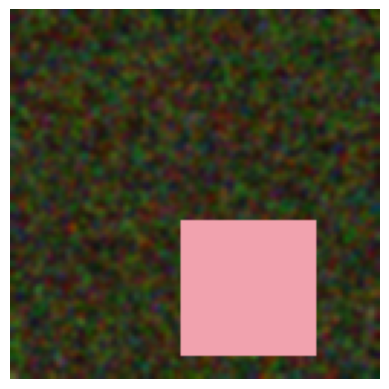

Label: [[list([82, 96]) 23 'square']]


In [10]:
# Generate a random index
index = np.random.randint(0, num_samples)

# Display image and label
plt.imshow(dataset_images[index])
plt.axis('off')
plt.show()
print("Label:", dataset_labels[index])

plt.close()


## Training

**Prepare Dataset**: Load the synthetic dataset and prepare it for training.

In [11]:
import torch
from torch.utils.data import DataLoader, Dataset

In [12]:
class SyntheticDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        # Create a single-channel label image
        label_image = np.zeros((image.shape[1], image.shape[2]), dtype=np.uint8)

        for center, size, shape_type in labels:
            if shape_type == 'square':
                top_left = (center[0] - size, center[1] - size)
                bottom_right = (center[0] + size, center[1] + size)
                label_image = cv2.rectangle(label_image, top_left, bottom_right, 1, -1)
            elif shape_type == 'circle':
                label_image = cv2.circle(label_image, center, size, 2, -1)
            elif shape_type == 'triangle':
                points = np.array([[center[0], center[1] - size],
                                [center[0] - size, center[1] + size],
                                [center[0] + size, center[1] + size]], np.int32)
                label_image = cv2.fillPoly(label_image, [points], 3)

        label_image = torch.from_numpy(label_image)

        return image, label_image

# Load the dataset
#dataset_images = np.load('dataset_images.npy')
#dataset_labels = np.load('dataset_labels.npy')

# Create the dataset and data loader
dataset = SyntheticDataset(dataset_images, dataset_labels)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)


**Define stop loss function and optimizer**: We will use the binary cross-entropy loss function and the Adam optimizer.

In [13]:
import torch.optim as optim

In [14]:
# Define the U-Net model
model = UNet(in_channels=3, out_channels=4)  # Assuming 3 input channels (RGB) and 4 output classes (background, square, circle, triangle)
if torch.cuda.is_available():
    model = model.cuda()  # Move the model to GPU if available

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

**Training the model**: Train the U-Net model on the synthetic dataset.

In [ ]:
# Training loop
num_epochs = 20  # Number of epochs
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in data_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        
        # Reshape outputs to match the input to CrossEntropyLoss
        outputs = outputs.permute(0, 2, 3, 1)  # (N, H, W, C)
        outputs = outputs.contiguous().view(-1, outputs.shape[-1])  # (N*H*W, C)
        labels = labels.view(-1)  # (N*H*W)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics
    epoch_loss = running_loss / len(data_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print('Training complete')


**Show training results**: Plot the loss curve and visualize the model's predictions on the test dataset.

In [ ]:
# Show training loss
plt.plot(
    range(len(losses)),
    losses
)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**Save the model**: Save the trained model for future use.

In [ ]:
# Save the model to disk
torch.save(model.state_dict(), 'unet_model.pth')

## Results

In [15]:
# Load the model from disk
model = UNet(in_channels=3, out_channels=4)

# Load the model state_dict
model.load_state_dict(torch.load('unet_model.pth'))

# Set the model to evaluation mode
model.eval()

UNet(
  (in_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Downscaling(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): Downscaling(
    (maxp

**Sample Prediction**: Visualize the model's predictions on a sample test image.

In [16]:
# Get a random sample from the dataset
index = np.random.randint(0, num_samples)
image, label = dataset[index]

# Prepare the image for inference
image = image.unsqueeze(0)  # Add batch dimension
if torch.cuda.is_available():
    image = image.cuda()

# Perform inference
with torch.no_grad():
    output = model(image)

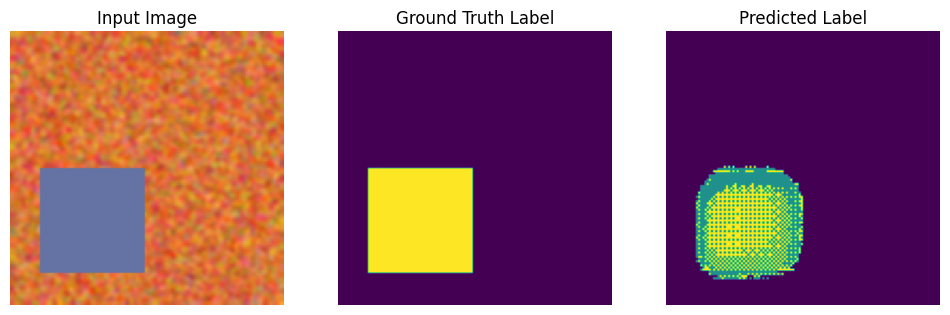

In [17]:
# Visualize the input, label, and output
image = image.cpu().squeeze().permute(1, 2, 0).numpy()
label = label.numpy()
output = output.cpu().squeeze().argmax(0).numpy()

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(label)
plt.title('Ground Truth Label')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output)
plt.title('Predicted Label')
plt.axis('off')

plt.show()